In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [4]:
cities = [
    ('New York City',  [
        'Kings County, NY','Queens County, NY', 'New York County, NY','Bronx County, NY',
'Richmond County, NY','Westchester County, NY','Bergen County, NJ','Hudson County, NJ',
'Passaic County, NJ','Putnam County, NY','Rockland County, NY','Suffolk County, NY',
'Nassau County, NY','Middlesex County, NJ','Monmouth County, NJ','Ocean County, NJ',
'Somerset County, NJ','Essex County, NJ','Union County, NJ','Morris County, NJ',
'Sussex County, NJ','Hunterdon County, NJ','Pike County, PA',]),
    
#     ('Los Angeles', ['Los Angeles County, CA','Orange County, CA']),
    
    ('Chicago', [
        'Cook County, IL','DeKalb County, IL','DuPage County, IL','Grundy County, IL',
'Kankakee County, IL','Kane County, IL','Kendall County, IL','McHenry County, IL',
'Will County, IL','Jasper County, IN','Lake County, IN','Newton County, IN',
'Porter County, IN','Lake County, IL', 'Kenosha County, WI'
    ]),
    
#     ('Houston', ['Harris County, TX','Austin County, TX','Brazoria County, TX',
# 'Chambers County, TX','Fort Bend County, TX','Galveston County, TX','Harris County, TX',
# 'Liberty County, TX','Montgomery County, TX','Waller County, TX']),
    
    ('Boston', ['Suffolk County, MA','Plymouth County, MA',
                      'Norfolk County, MA','Essex County, MA', 'Middlesex County, MA',
                     'Rockingham County, NH', 'Strafford County, NH']),

#     ('Phoenix', ['Maricopa County, AZ','Pinal County, AZ','Gila County, AZ']),
    ('Philadelphia', ['Burlington County, NJ','Camden County, NJ','Gloucester County,NJ',
     'Bucks County, PA', 'Chester County, PA', 'Montgomery County, PA',
                           'Delaware County, PA', 'Philadelphia County, PA',
                           'New Castle County, DE', 'Cecil County, MD', 'Salem County, NJ']),
    
#     ('San Antonio', ['Bexar County, TX','Atascosa County, TX','Bandera County, TX','Comal County, TX',
#                           'Guadalupe County, TX','Kendall County, TX','Medina County, TX','Wilson County, TX']),
    
#     ('San Diego', 'ca', ['San Diego County, CA']),
    
#     ('Dallas',  ['Collin County, TX','Dallas County, TX','Denton County, TX','Ellis County, TX',
# 'Hunt County, TX','Kaufman County, TX','Rockwall County, TX','Johnson County, TX','Parker County, TX',
# 'Tarrant County, TX','Wise County, TX']),

]

# baseline

### unconstrain model, power law

In [5]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [6]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [9]:
minValue = []
maxValue = []
for city, counties in cities:
    df = pd.read_csv(f'processedOD/{city}.csv')
    df['distance'] = df['distance']/1.6
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
#     df = pd.to_csv(f'income/{city}.csv',index=)
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-1.5641366604115838 5.020043037266068


In [10]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [16]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.002*len(df)),2000)
    thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)

            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [17]:

# arbitarily set bin=40

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 2000
for rate in np.arange(0.0007,0.01,0.0001):
    fdworsecounttemp = 0
    for city, counties in cities:
        print(city)
        df = pd.read_csv(f'income/{city}.csv')
        df['distance'] = df['distance']/1.6
        df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(0.5),np.log(50),40+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)

        binfdf = pd.DataFrame()

        # fd
        for target in ['SE01','SE03','S000']:
            traindf, testdf = train_test_split(df, test_size=0.2)
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            print(target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
            resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                    [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
            resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                    [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

            fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
            print('is',round(fdmseis,2),
                  'os',round(fdmseos,2))
        # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
                [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
            resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
                [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

            blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            print('is',round(blmseis,2),
                  'os',round(blmseos,2))
            if fdmseos > blmseos:
                fdworsecounttemp += 1
    fdworsecount += [fdworsecounttemp]

New York City
SE01
is 0.46 os 0.48
is 0.46 os 0.48
SE03
is 1.9 os 2.03
is 1.92 os 2.04
S000
is 5.76 os 6.22
is 5.81 os 6.26
Chicago
SE01
is 1.28 os 1.43
is 1.32 os 1.45
SE03
is 5.15 os 6.5
is 6.56 os 8.29
S000
is 16.16 os 17.0
is 18.03 os 18.45
Boston
SE01
is 4.11 os 4.08
is 4.13 os 4.12
SE03
is 15.07 os 15.75
is 15.28 os 15.81
S000
is 52.33 os 46.7
is 52.8 os 47.08
Philadelphia
SE01
is 1.75 os 1.61
is 1.77 os 1.62
SE03
is 6.74 os 7.38
is 7.5 os 7.47
S000
is 21.43 os 21.54
is 22.37 os 22.06
New York City
SE01
is 0.47 os 0.47
is 0.47 os 0.47
SE03
is 1.93 os 1.92
is 1.96 os 1.93
S000
is 5.9 os 5.85
is 5.95 os 5.9
Chicago
SE01
is 1.37 os 1.48
is 1.4 os 1.52
SE03
is 5.67 os 4.56
is 7.19 os 5.95
S000
is 16.37 os 17.51
is 18.16 os 19.38
Boston
SE01
is 4.12 os 4.03
is 4.16 os 4.01
SE03
is 15.22 os 15.21
is 15.41 os 15.28
S000
is 51.13 os 51.54
is 51.64 os 51.75
Philadelphia
SE01
is 1.72 os 1.72
is 1.74 os 1.72
SE03
is 6.76 os 7.11
is 7.5 os 7.49
S000
is 21.35 os 21.72
is 22.27 os 22.48
New Yo

SE01
is 4.01 os 4.48
is 4.04 os 4.5
SE03
is 15.3 os 14.86
is 15.5 os 14.91
S000
is 51.82 os 48.83
is 52.32 os 49.04
Philadelphia
SE01
is 1.82 os 1.85
is 1.84 os 1.86
SE03
is 7.14 os 7.38
is 7.74 os 8.17
S000
is 22.36 os 24.61
is 23.36 os 24.59
New York City
SE01
is 0.6 os 0.6
is 0.6 os 0.6
SE03
is 2.2 os 2.12
is 2.23 os 2.14
S000
is 7.12 os 7.48
is 7.18 os 7.55
Chicago
SE01
is 2.19 os 2.41
is 2.24 os 2.4
SE03
is 6.85 os 5.79
is 8.23 os 7.57
S000
is 22.29 os 23.74
is 24.35 os 24.52
Boston
SE01
is 4.13 os 3.99
is 4.16 os 4.01
SE03
is 15.03 os 15.95
is 15.22 os 16.06
S000
is 50.49 os 54.1
is 51.03 os 54.21
Philadelphia
SE01
is 1.84 os 1.87
is 1.86 os 1.85
SE03
is 7.16 os 7.65
is 7.82 os 8.1
S000
is 23.04 os 22.48
is 24.01 os 22.71
New York City
SE01
is 0.61 os 0.6
is 0.61 os 0.6
SE03
is 2.23 os 2.1
is 2.26 os 2.12
S000
is 7.15 os 7.87
is 7.21 os 7.91
Chicago
SE01
is 2.21 os 2.49
is 2.25 os 2.53
SE03
is 6.52 os 7.35
is 7.99 os 8.91
S000
is 22.36 os 25.42
is 24.38 os 26.05
Boston
SE01
is 4.

SE01
is 0.77 os 0.72
is 0.77 os 0.72
SE03
is 2.49 os 2.59
is 2.51 os 2.61
S000
is 8.71 os 8.94
is 8.76 os 8.97
Chicago
SE01
is 2.92 os 2.54
is 2.97 os 2.52
SE03
is 7.54 os 8.0
is 8.98 os 9.54
S000
is 27.78 os 26.9
is 29.65 os 28.49
Boston
SE01
is 5.24 os 4.48
is 5.27 os 4.46
SE03
is 17.87 os 18.45
is 18.04 os 18.48
S000
is 62.38 os 64.22
is 62.85 os 64.33
Philadelphia
SE01
is 2.26 os 2.41
is 2.28 os 2.42
SE03
is 8.86 os 7.92
is 9.48 os 8.75
S000
is 27.97 os 28.85
is 28.91 os 29.35
New York City
SE01
is 0.76 os 0.79
is 0.76 os 0.79
SE03
is 2.52 os 2.57
is 2.54 os 2.58
S000
is 8.88 os 8.81
is 8.92 os 8.87
Chicago
SE01
is 2.89 os 2.82
is 2.94 os 2.83
SE03
is 7.86 os 6.99
is 9.33 os 8.36
S000
is 27.82 os 28.43
is 29.68 os 30.09
Boston
SE01
is 5.05 os 5.53
is 5.08 os 5.52
SE03
is 17.94 os 19.11
is 18.11 os 19.09
S000
is 63.57 os 63.78
is 63.98 os 64.04
Philadelphia
SE01
is 2.3 os 2.38
is 2.32 os 2.4
SE03
is 8.79 os 8.85
is 9.53 os 9.02
S000
is 28.38 os 29.01
is 29.35 os 29.32
New York City


S000
is 33.71 os 32.97
is 35.41 os 34.14
Boston
SE01
is 6.52 os 6.06
is 6.55 os 6.09
SE03
is 20.89 os 20.49
is 21.0 os 20.71
S000
is 76.5 os 78.53
is 77.09 os 78.21
Philadelphia
SE01
is 2.7 os 2.78
is 2.72 os 2.79
SE03
is 10.01 os 9.42
is 10.75 os 9.64
S000
is 32.59 os 35.09
is 33.54 os 35.36
New York City
SE01
is 0.93 os 0.91
is 0.92 os 0.91
SE03
is 2.8 os 2.94
is 2.82 os 2.95
S000
is 10.35 os 10.35
is 10.39 os 10.38
Chicago
SE01
is 3.6 os 3.12
is 3.62 os 3.13
SE03
is 9.1 os 8.86
is 10.29 os 10.57
S000
is 33.86 os 34.64
is 35.39 os 35.86
Boston
SE01
is 6.51 os 6.28
is 6.54 os 6.32
SE03
is 20.79 os 21.74
is 20.9 os 21.86
S000
is 78.56 os 73.09
is 79.03 os 73.13
Philadelphia
SE01
is 2.72 os 2.82
is 2.73 os 2.84
SE03
is 10.02 os 10.16
is 10.65 os 10.66
S000
is 33.29 os 34.01
is 34.13 os 34.59
New York City
SE01
is 0.93 os 0.92
is 0.93 os 0.91
SE03
is 2.88 os 2.7
is 2.9 os 2.71
S000
is 10.4 os 10.58
is 10.44 os 10.6
Chicago
SE01
is 3.52 os 3.77
is 3.55 os 3.78
SE03
is 9.18 os 8.72
is 10.5

SE03
is 24.59 os 23.27
is 24.69 os 23.31
S000
is 93.17 os 87.05
is 93.73 os 87.31
Philadelphia
SE01
is 3.2 os 3.05
is 3.21 os 3.05
SE03
is 11.12 os 12.08
is 11.77 os 11.87
S000
is 38.76 os 36.9
is 39.33 os 38.0
New York City
SE01
is 1.06 os 1.09
is 1.05 os 1.08
SE03
is 3.14 os 3.29
is 3.15 os 3.29
S000
is 11.98 os 11.24
is 12.0 os 11.27
Chicago
SE01
is 3.86 os 4.2
is 3.9 os 4.17
SE03
is 9.92 os 10.99
is 11.08 os 12.36
S000
is 38.72 os 36.32
is 40.19 os 37.72
Boston
SE01
is 7.87 os 7.43
is 7.93 os 7.46
SE03
is 24.28 os 25.08
is 24.43 os 24.94
S000
is 92.12 os 94.81
is 92.59 os 95.52
Philadelphia
SE01
is 3.16 os 3.36
is 3.17 os 3.37
SE03
is 11.44 os 11.0
is 11.91 os 11.82
S000
is 38.7 os 39.54
is 39.41 os 39.91
New York City
SE01
is 1.08 os 1.04
is 1.07 os 1.03
SE03
is 3.17 os 3.25
is 3.18 os 3.26
S000
is 11.84 os 12.06
is 11.87 os 12.06
Chicago
SE01
is 3.75 os 4.72
is 3.79 os 4.71
SE03
is 9.98 os 11.0
is 11.07 os 12.57
S000
is 38.4 os 38.52
is 39.96 os 39.58
Boston
SE01
is 7.93 os 7.62


KeyboardInterrupt: 

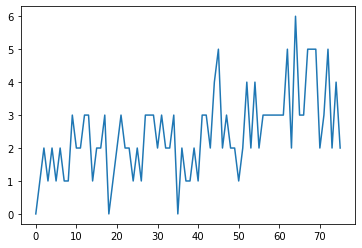

In [18]:
plt.plot(fdworsecount)

In [63]:


# 5-fold 
resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
number = 2000
fdworsecounttemp = 0
rate = np.arange(0.0007,0.01,0.0001)[20]
for city, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),40+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()
    skf = StratifiedKFold(n_splits=5)
    skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
        # fd
    for target in ['SE01','SE03','S000']:
        print(target)

        fdmseis = 0
        fdmseos = 0
        blmseis = 0
        blmseos = 0
        for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
            traindf, testdf = df.iloc[train_index], df.iloc[test_index]
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            fdmseis += mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos += mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
           
        
            # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            
        resultsfd40is[city] = resultsfd40is.get(city,[])+ [round(fdmseis/5,2)]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ [round(fdmseos/5,2)]
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + [round(blmseis/5,2)]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + [round(blmseos/5,2)]
        print('is',round(fdmseis/5,2),'os',round(fdmseos/5,2))
        print('is',round(blmseis/5,2),'os',round(blmseos/5,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1


New York City
SE01
is 0.63 os 0.63
is 0.63 os 0.63
SE03
is 2.26 os 2.26
is 2.28 os 2.28
S000
is 7.51 os 7.52
is 7.56 os 7.57
Chicago
SE01
is 2.33 os 2.39
is 2.37 os 2.4
SE03
is 6.75 os 6.99
is 8.27 os 8.37
S000
is 23.35 os 23.82
is 25.23 os 25.48
Boston
SE01
is 4.24 os 4.27
is 4.27 os 4.28
SE03
is 15.48 os 15.6
is 15.68 os 15.69
S000
is 52.57 os 52.8
is 53.06 os 53.08
Philadelphia
SE01
is 1.9 os 1.92
is 1.92 os 1.92
SE03
is 7.42 os 7.75
is 8.11 os 8.16
S000
is 23.58 os 24.05
is 24.48 os 24.54


In [65]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,7.56,7.51,0.63,0.63,2.28,2.26
Chicago,25.23,23.35,2.37,2.33,8.27,6.75
Boston,53.06,52.57,4.27,4.24,15.68,15.48
Philadelphia,24.48,23.58,1.92,1.90,8.11,7.42


In [66]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,7.57,7.52,0.63,0.63,2.28,2.26
Chicago,25.48,23.82,2.40,2.39,8.37,6.99
Boston,53.08,52.80,4.28,4.27,15.69,15.60
Philadelphia,24.54,24.05,1.92,1.92,8.16,7.75


In [67]:

# arbitarily set bin=40

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 2000
fdworsecounttemp = 0
rate = np.arange(0.0007,0.01,0.0001)[20]
for city, counties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),40+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        traindf, testdf = train_test_split(df, test_size=0.2)
        binf,k = unconstrained_bucked_constant_kfit(traindf, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
        df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

        fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
        fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
        print('is',round(fdmseis,2),
              'os',round(fdmseos,2))
    # baseline 
        pars = baseline_fit(traindf,target)
        df_baselineis = baseline_predict(traindf,target,pars)
        df_baselineos = baseline_predict(testdf,target,pars)
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
            [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
            [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

        blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
        blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
        print('is',round(blmseis,2),
              'os',round(blmseos,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1
fdworsecount += [fdworsecounttemp]

New York City
SE01
is 0.63 os 0.62
is 0.63 os 0.62
SE03
is 2.28 os 2.19
is 2.3 os 2.21
S000
is 7.6 os 7.15
is 7.66 os 7.2
Chicago
SE01
is 2.33 os 2.35
is 2.38 os 2.36
SE03
is 6.72 os 7.05
is 8.15 os 8.86
S000
is 23.43 os 23.3
is 25.36 os 24.84
Boston
SE01
is 4.2 os 4.42
is 4.23 os 4.44
SE03
is 15.52 os 15.4
is 15.72 os 15.5
S000
is 52.78 os 51.98
is 53.21 os 52.45
Philadelphia
SE01
is 1.89 os 1.97
is 1.9 os 1.99
SE03
is 7.3 os 8.15
is 8.0 os 8.58
S000
is 23.96 os 22.42
is 24.86 os 23.01


In [68]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income1[bins],income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income3[bins],income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income0[bins],income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

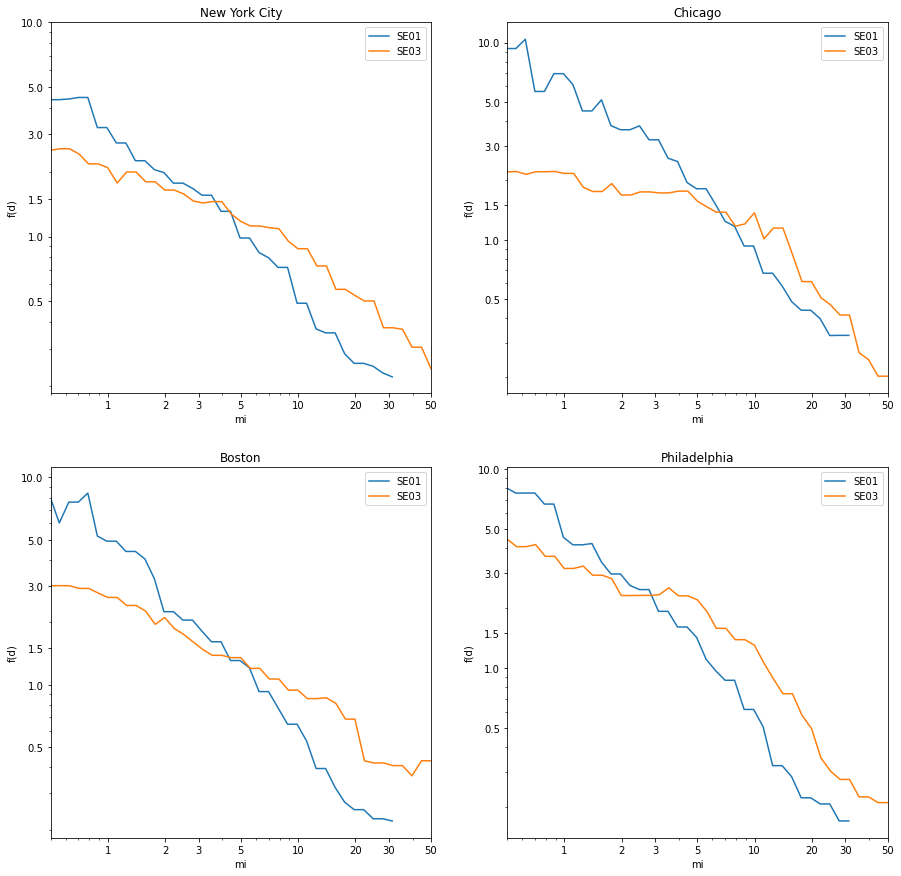

In [69]:
# 0.2% / 2000

fig,ax = plt.subplots(2,2,figsize=(15,15))
i= 0
for city, counties in cities:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df.bin = df.bin/1.6
    ax[i//2,i%2].set_xlim(0.5,50)
    ax[i//2,i%2].plot(df['bin'],df['fd'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df = df.sort_values(by='bin')

    
    ax[i//2,i%2].plot(df['bin'],df['fd'],label='SE03')

    ax[i//2,i%2].set_title(city)
    ax[i//2,i%2].legend()
    ax[i//2,i%2].set_yscale('log')
    ax[i//2,i%2].set_xscale('log')
    ax[i//2,i%2].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//2,i%2].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//2,i%2].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//2,i%2].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//2,i%2].set_ylabel('f(d)')
    ax[i//2,i%2].set_xlabel('mi')
    i += 1
      
# plt.savefig('curve.png')

In [59]:
df.shape

(41, 2)